# Magic states and T-gadgets with Qiskit

## Theory


Assume that we want to prepare (or simulate) 
$$\rho=U |0\dots0 \rangle_{\rm sys} \langle 0\dots 0|_{\rm sys} U^\dagger,$$

where $U$ is an arbitrary circuit compiled into the $H$, $S$, $CNOT$, $T$ gateset.

Assume that the number of $T$ gates, also known as T-count, is $t$.

Using magic states and T-gadgets, it can be shown [Bravyi, Gosset (2016)](https://arxiv.org/abs/1601.07601) that:

$$\rho = 2^t \, {\rm tr_{aux}}[\rho' (I \otimes |0\dots0 \rangle_{\rm aux} \langle 0\dots 0|_{\rm aux}) ],$$

where $$\rho'= U' (|0\dots0 \rangle_{\rm sys}\langle 0\dots 0|_{\rm sys} \otimes |T\dots T \rangle_{\rm aux}  \langle T\dots T|_{\rm aux}) U'^\dagger,$$

$|T\dots T \rangle_{\rm aux}  \langle T\dots T|_{\rm aux}$ is the tensor product of $t$ magic states.

$$|T\rangle = T\, H\, |0\rangle, \text{ (magic state)}$$  

and, **importantly**, $U'$ is a Clifford circuit.

More precisely, $U'$ is obtained from $U$ by replacing all $T$ gates with $CNOT$ gates connecting qubits of the system and magic states.

**NOTE:** This is just a particular way of using T-gadgets and it corresponds to just a particular post-selected string of results on the auxiliary qubits (the string with $0 \dots 0$).


## Setting

In [1]:
import qiskit
from qiskit import QuantumCircuit
from qiskit.quantum_info import Pauli

import numpy as np
from matplotlib import pyplot as plt


n_qubits = 5
n_bits = n_qubits
num_t = 5
shots = 100000

In [2]:
def chop_and_real(x, eps = 1e-10):
    """Chop values of Numpy arrays."""
    y = np.copy(x)
    y[np.abs(x) < eps] = 0
    return np.real(y)

def random_pauli_string(n_qubits, seed=None):
    """Sample a random pauli string. """
    if seed is None:
        rnd_state = np.random
    else:
        rnd_state = np.random.RandomState(seed)  
    rnd_paulis = rnd_state.choice(["I", "X", "Y", "Z"], n_qubits, replace=True)
    return "".join(rnd_paulis)

random_pauli_string(5)

'IZIXY'

In [3]:
def sample_pauli_strings(num_paulis, n_qubits, with_replacement=False, seed=None):
    """Returns a list of random Pauli strings sorted from many Is to few Is."""
    max_iterations = 10 ** 4
    sampled_paulis = []

    for j in range(max_iterations):
        if len(sampled_paulis) == num_paulis:
            sampled_paulis = sorted(
                sampled_paulis, key=lambda x: -sum([int(c=="I") for c in x])
            )
            return sampled_paulis
        
        sampled_paulis.append(random_pauli_string(n_qubits, seed=j))
        
        if not with_replacement:
            sampled_paulis = list(set(sampled_paulis))
            
    raise RuntimeError("Max number of iterations reached.")



sample_pauli_strings(5, n_qubits=n_qubits)

['IZXIZ', 'YIXZI', 'IZXIY', 'XZIIZ', 'YYZXX']

## Generate a random Clifford+T circuit.

In [24]:
def rnd_clifford_t_circuit(n_qubits, n_bits, num_t, t_gadget=False, randomize=False, seed=None, magic_prep=True, seed_s=None):
    """Makes a random circuit with Clifford gates and T gates."""
    
    if n_qubits < 5:
        raise ValueError("The number of qubits must be at least 5.")
    
    # init rnd number generator
    if seed is None:
        rnd_state = np.random
    else:
        rnd_state = np.random.RandomState(seed)
    
    if seed is None:
        rnd_state_s = np.random
    else:
        rnd_state_s = np.random.RandomState(seed_s)
        
    # Init circuit
    if not t_gadget:
        circuit = QuantumCircuit(n_qubits, n_bits)
    else:
        circuit = QuantumCircuit(n_qubits + num_t, n_bits + num_t)
        # Prepare magic states
        if magic_prep:
            for idx in range(num_t):
                circuit.h(n_qubits + idx)
                circuit.t(n_qubits + idx)

    # Random circuit of CNOT, H, S and T gates
    qubit_indices = list(range(n_qubits))
    
    for idx in range(n_qubits):
        circuit.h(idx)
    
    for idx in range(num_t):
        cnot_a, cnot_b, h, s, t = rnd_state.choice(qubit_indices, 5, replace=False)
        circuit.cx(cnot_a, cnot_b)
        circuit.h(h)
        circuit.s(s)
        if not t_gadget:
            circuit.t(t)
        elif not randomize:
            circuit.cnot(t, n_qubits + idx)
        else:
            circuit.cnot(t, n_qubits + idx)
            if rnd_state_s.randint(2): # apply t-gadget adaptive correction
                circuit.s(t)
                circuit.x(n_qubits + idx)

    return circuit

Let us print a random Clifford+T circuit:

In [25]:
circuit = rnd_clifford_t_circuit(n_qubits=n_qubits, n_bits=n_bits, num_t=num_t, t_gadget=False, seed=0)
print(circuit)

     ┌───┐┌───┐          ┌───┐┌───┐┌───┐          
q_0: ┤ H ├┤ X ├───────■──┤ S ├┤ T ├┤ T ├──────────
     ├───┤└─┬─┘┌───┐  │  ├───┤└───┘├───┤┌───┐     
q_1: ┤ H ├──┼──┤ H ├──┼──┤ H ├──■──┤ X ├┤ S ├─────
     ├───┤  │  └───┘┌─┴─┐├───┤  │  └─┬─┘├───┤┌───┐
q_2: ┤ H ├──■───────┤ X ├┤ T ├──┼────┼──┤ H ├┤ X ├
     ├───┤┌───┐┌───┐└───┘└───┘┌─┴─┐  │  ├───┤└─┬─┘
q_3: ┤ H ├┤ S ├┤ T ├──────────┤ X ├──■──┤ H ├──┼──
     ├───┤├───┤├───┤┌───┐┌───┐└───┘     └───┘  │  
q_4: ┤ H ├┤ T ├┤ S ├┤ H ├┤ S ├─────────────────■──
     └───┘└───┘└───┘└───┘└───┘                    
c: 5/═════════════════════════════════════════════
                                                  


Let us print the corresponding T-gadget version (assuming auxiliary qubits are projected on the zero state).

In [26]:
circuit_with_gadgets = rnd_clifford_t_circuit(n_qubits=n_qubits, n_bits=n_bits, num_t=num_t, t_gadget=True, seed=0)
print(circuit_with_gadgets)

      ┌───┐┌───┐          ┌───┐                                   
 q_0: ┤ H ├┤ X ├───────■──┤ S ├──────────────────────■────■───────
      ├───┤└─┬─┘┌───┐  │  ├───┤          ┌───┐┌───┐  │    │       
 q_1: ┤ H ├──┼──┤ H ├──┼──┤ H ├──■───────┤ X ├┤ S ├──┼────┼───────
      ├───┤  │  └───┘┌─┴─┐└───┘  │       └─┬─┘├───┤  │    │  ┌───┐
 q_2: ┤ H ├──■───────┤ X ├───────┼────■────┼──┤ H ├──┼────┼──┤ X ├
      ├───┤┌───┐     └───┘     ┌─┴─┐  │    │  ├───┤  │    │  └─┬─┘
 q_3: ┤ H ├┤ S ├───────■───────┤ X ├──┼────■──┤ H ├──┼────┼────┼──
      ├───┤└───┘       │  ┌───┐├───┤  │  ┌───┐└───┘  │    │    │  
 q_4: ┤ H ├───────■────┼──┤ S ├┤ H ├──┼──┤ S ├───────┼────┼────■──
      ├───┤┌───┐┌─┴─┐  │  └───┘└───┘  │  └───┘       │    │       
 q_5: ┤ H ├┤ T ├┤ X ├──┼──────────────┼──────────────┼────┼───────
      ├───┤├───┤└───┘┌─┴─┐            │              │    │       
 q_6: ┤ H ├┤ T ├─────┤ X ├────────────┼──────────────┼────┼───────
      ├───┤├───┤     └───┘          ┌─┴─┐            │    │   

## Execute the circuit

First we evaluate an expectation value as usual, i.e., without T-gadgets.

In [27]:
def compute_pauli_expval_with_shots(circuit, pauli, shots):
    """Compute the expectation value of a Pauli observable.
    """
    if not set(pauli).issubset(set("IZ")):
        raise ValueError("The input pauli must contain only I or Z terms. E.g. IZZIZ.")
    circuit_to_measure = circuit.copy()
    circuit_to_measure.measure_all()
    
    #backend = AerSimulator(method='extended_stabilizer')
    backend = qiskit.Aer.get_backend('aer_simulator_statevector')
    job = backend.run(circuit_to_measure, shots=shots)
    result = job.result()
    if not result.success:
        print("Simulation failed")
        
    unnormalized_exp_val = 0
    for key, counts in result.get_counts().items():
        ones_on_z = [1 for bit, p in zip(key, pauli) if (bit=="1" and p=="Z")]
        parity = sum(ones_on_z) % 2
        unnormalized_exp_val += counts * (-1) ** parity
    
    return unnormalized_exp_val / shots


In [28]:
pauli_to_measure = "ZIIII"
circuit = rnd_clifford_t_circuit(n_qubits=n_qubits, n_bits=n_bits, num_t=num_t, t_gadget=False, seed=0)
compute_pauli_expval_with_shots(circuit, pauli=pauli_to_measure, shots=shots)

-0.71068

In [29]:
def compute_pauli_expval_with_state(circuit, pauli):
    """Compute the expectation value of a Pauli observable.
    """
    
    circuit_to_measure = circuit.copy()
    circuit_to_measure.save_density_matrix()
    
    #backend = AerSimulator(method='extended_stabilizer')
    backend = qiskit.Aer.get_backend('aer_simulator_statevector')
    job = backend.run(circuit_to_measure)
    result = job.result()
      
    if not result.success:
        print("Simulation failed")
    
    rho = result.data()["density_matrix"]
    obs = qiskit.quantum_info.Pauli(pauli).to_matrix()
    return chop_and_real(np.trace(rho @ obs))

pauli_to_measure = "ZIIII"
circuit = rnd_clifford_t_circuit(n_qubits=n_qubits, n_bits=n_bits, num_t=num_t, t_gadget=False, seed=0)
print(compute_pauli_expval_with_state(circuit, pauli=pauli_to_measure))

-0.707106781186547


# T-gadget simulation

We remove all T gates to get a clifford circuit.

In [10]:
def compute_pauli_expval_with_gadget(circuit, pauli):
    """Compute the expectation value of a Pauli observable.
    """

    circuit_to_measure = circuit.copy()
    circuit_to_measure.save_density_matrix()

    #backend = AerSimulator(method='extended_stabilizer')
    backend = qiskit.Aer.get_backend('aer_simulator_statevector')
    job = backend.run(circuit_to_measure)
    result = job.result()

    if not result.success:
        print("Simulation failed")

    rho = result.data()["density_matrix"]
    
    extended_pauli = num_t*"I" + pauli
    obs = qiskit.quantum_info.Pauli(extended_pauli).to_matrix()
    
    # Define projector on gadget qubits
    id_on_sys = np.eye(2 ** n_qubits)
    proj_on_zero_aux = np.zeros((2 ** num_t, 2 ** num_t))
    proj_on_zero_aux[0, 0] = 1
    
    gadjet_projector = np.kron(proj_on_zero_aux, id_on_sys)
    return (2 ** num_t) * chop_and_real(np.trace(rho @ obs @ gadjet_projector))

circuit_without_t = rnd_clifford_t_circuit(n_qubits=n_qubits, n_bits=n_bits, num_t=num_t, t_gadget=True, randomize=True, seed=0, seed_s = 1)
compute_pauli_expval_with_gadget(circuit_without_t, pauli="ZIIII")

-0.707106781186547

## Test equivalence between direct simulation and T-gadget simulation

To compare the two methods we generate a list random Pauli strings and we evaluate their expectation values with both methods.

In [11]:
sampled_paulis = sample_pauli_strings(100, n_qubits=n_qubits, with_replacement=False)
print(f"{len(sampled_paulis)} random Paulis sampled.")

100 random Paulis sampled.


In [12]:
%%time

heavy_paulis = []
heavy_expvals = []

for pauli in sampled_paulis:
    circuit = rnd_clifford_t_circuit(n_qubits=n_qubits, n_bits=n_bits, num_t=num_t, seed=0)
    circuit_with_gadget = rnd_clifford_t_circuit(n_qubits=n_qubits, n_bits=n_bits, num_t=num_t, t_gadget=True, seed=0)
    expval_direct = compute_pauli_expval_with_state(circuit, pauli)
    # Skip zero expectation values
    if np.isclose(expval_direct, 0.0):
        continue
    
    expval_with_gadget = compute_pauli_expval_with_gadget(circuit_with_gadget, pauli)
    assert np.isclose(expval_direct, expval_with_gadget)
    heavy_paulis.append(pauli)
    heavy_expvals.append(expval_direct)
    print(f"Pauli: {pauli} \texpval_direct: {expval_direct:.4} \texpval_with_gadget: {expval_with_gadget:.4}")

Pauli: IZIYI 	expval_direct: -0.7071 	expval_with_gadget: -0.7071
Pauli: IIZXI 	expval_direct: 0.3536 	expval_with_gadget: 0.3536
Pauli: IIZXX 	expval_direct: -0.3536 	expval_with_gadget: -0.3536
Pauli: XZXIX 	expval_direct: -0.7071 	expval_with_gadget: -0.7071
Pauli: YZZXI 	expval_direct: 0.3536 	expval_with_gadget: 0.3536
Pauli: IZYYX 	expval_direct: 0.3536 	expval_with_gadget: 0.3536
Pauli: ZZYXX 	expval_direct: -0.5 	expval_with_gadget: -0.5
CPU times: user 11.2 s, sys: 5.57 s, total: 16.8 s
Wall time: 1.55 s


In [13]:
print(f"{len(heavy_paulis)} heavy Paulis ({len(heavy_paulis)/len(sampled_paulis):.00%}) computed.")

7 heavy Paulis (7%) computed.


## Linear combination of paulis

We want to compute $E= {\rm tr}(\rho P)$, where $\rho=U |0\dots0 \rangle_{\rm sys} \langle 0\dots 0|_{\rm sys} U^\dagger$ and $P$ is a Pauli operator.

The previous code shows that, through T-gadgets, we can evaluate the same expectation value as:

$$E= 2^t \, {\rm tr}[\rho' (P \otimes |0\dots0 \rangle_{\rm aux} \langle 0\dots 0|_{\rm aux}) ],$$

where $$\rho'= U' (|0\dots0 \rangle_{\rm sys}\langle 0\dots 0|_{\rm sys} \otimes |T\dots T \rangle_{\rm aux}  \langle T\dots T|_{\rm aux}) U'^\dagger,$$

$|T\rangle = T\, H\, |0\rangle$ is a magic state and, **importantly**, $U'$ is a Clifford circuit..

If the observable is a Pauli operator, can we try to use an Heisenberg-picture-like approach to evaluate its expectation value?

This requires expanding final zero-state-projector on the auxiliary qubits as a linear combination of Pauli strings. We use:

$$ |0\dots 0 \rangle \langle 0\dots 0| = \prod_{j=1}^{t} \frac{(I_j + Z_j)}{2}=\frac{1}{2^t}\sum_{b \in \{0, 1\}^{\otimes t}} Z^{b_1}Z^{b_2}\dots Z^{b_t}. $$

So it is possible to expand $P \otimes |0\dots0 \rangle_{\rm aux} \langle 0\dots 0|_{\rm aux}$ as a linear combination of Pauli strings. Unfortunately the number of terms is $2^t$, so exponential in $t$.

In [14]:
def paulis_of_zero_projector(n_qubits: int):
    """Returns a list of pauli strings corresponding (up to normalization)
    to the projector on the zero state of n_qubits"""
    paulis = ["I", "Z"]
    for _ in range(n_qubits - 1):
        new_paulis = []
        for pauli in paulis:
            new_paulis.append(pauli + "I")
            new_paulis.append(pauli + "Z")
        paulis = new_paulis
    # Sort from few Zs to many Zs
    return sorted(paulis, key=lambda x: sum([int(c=="Z") for c in x]))
paulis_of_zero_projector(3)

['III', 'IIZ', 'IZI', 'ZII', 'IZZ', 'ZIZ', 'ZZI', 'ZZZ']

In [15]:
def compute_pauli_expval_with_gadget_and_linear_comb(circuit, pauli):
    """Computes the expectation value of a Pauli observable expanding the projector on the magic states
    as a linear combination of Pauli operators.
    
    Returns: The expectation value and also individual terms before averaging.
    """
    circuit_to_measure = circuit.copy()
    circuit_to_measure.save_density_matrix()

    #backend = AerSimulator(method='extended_stabilizer')
    backend = qiskit.Aer.get_backend('aer_simulator_statevector')
    job = backend.run(circuit_to_measure)
    result = job.result()
    if not result.success:
        print("Simulation failed")
    rho = result.data()["density_matrix"]
    
    # Expand zero-state projector on gadget qubits
    all_paulis = [Pauli(p + pauli) for p in paulis_of_zero_projector(num_t)]
    
    all_expvals = chop_and_real([np.trace(rho @ p.to_matrix()) for p in all_paulis])

    return np.sum(all_expvals), all_expvals, 

In [16]:
%%time

circuit = rnd_clifford_t_circuit(n_qubits=n_qubits, n_bits=n_bits, num_t=num_t, t_gadget=True, randomize=False, seed=0)

heavy_all_expvals = []
for _pauli, _expval in zip(heavy_paulis, heavy_expvals):
    estimate, all_expvals = compute_pauli_expval_with_gadget_and_linear_comb(circuit, pauli=_pauli)
    print(f"Pauli: {_pauli} \texpval_direct: {_expval:.4} \texpval_with_gadget: {estimate:.4}")    
    heavy_all_expvals.append(all_expvals)

Pauli: IZIYI 	expval_direct: -0.7071 	expval_with_gadget: -0.7071
Pauli: IIZXI 	expval_direct: 0.3536 	expval_with_gadget: 0.3536
Pauli: IIZXX 	expval_direct: -0.3536 	expval_with_gadget: -0.3536
Pauli: XZXIX 	expval_direct: -0.7071 	expval_with_gadget: -0.7071
Pauli: YZZXI 	expval_direct: 0.3536 	expval_with_gadget: 0.3536
Pauli: IZYYX 	expval_direct: 0.3536 	expval_with_gadget: 0.3536
Pauli: ZZYXX 	expval_direct: -0.5 	expval_with_gadget: -0.5
CPU times: user 1min 59s, sys: 1min 2s, total: 3min 2s
Wall time: 16.2 s


In [17]:
def plot_all_heavy_terms(heavy_paulis, heavy_expvals, heavy_all_expvals):
    """Plot all the terms which, when added, produce the expectation value of each Pauli string."""
    # Sort heavy paulis from large abs(expval) to small abs(expval)
    sorted_zip = sorted(zip(heavy_paulis, heavy_expvals, heavy_all_expvals), key=lambda x: -abs(x[1]))
    plt.figure(figsize=(6, 6))
    shift = 0.0
    for _pauli, expval, all_expvals in sorted_zip[:10]:
            shift += 0.0005
            plt.plot(all_expvals + shift, marker="o", linestyle="None", label=_pauli +f" ({expval:g})", alpha=0.3)
            plt.legend(bbox_to_anchor=(1.25, 1))
    plt.title("Individual terms whose sum gives the expectation value of a Pauli string")
    plt.show()
    
    plt.figure(figsize=(4, 4))
    plt.plot(np.mean(np.abs(heavy_all_expvals), axis=0), marker=".")
    plt.title("Average norm of each term")
    plt.show()

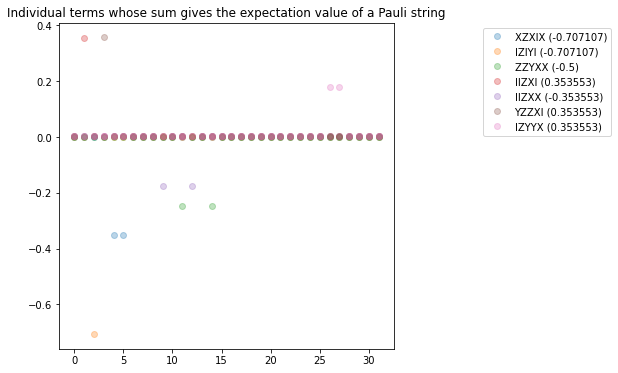

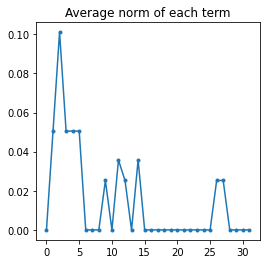

In [18]:
plot_all_heavy_terms(heavy_paulis, heavy_expvals, heavy_all_expvals)

## Magic state |T> in the Pauli basis

The magic sate $|T\rangle=TH|0\rangle$ has known expectation values with respect to the Pauli basis: 
$$\langle T | I |T\rangle=1,$$ 
$$\langle T | Y |T\rangle=\langle T | X |T\rangle=1/\sqrt{2},$$
$$\langle T | Z |T\rangle=0.$$

We numerically verify this fact.

In [19]:
t_circuit = QuantumCircuit(1)
t_circuit.h(0)
t_circuit.t(0)

assert np.isclose(compute_pauli_expval_with_state(t_circuit, "I"), 1)
assert np.isclose(compute_pauli_expval_with_state(t_circuit, "X"), 1 / np.sqrt(2))
assert np.isclose(compute_pauli_expval_with_state(t_circuit, "Y"), 1 / np.sqrt(2))
assert np.isclose(compute_pauli_expval_with_state(t_circuit, "Z"), 0)

## Linear combination of paulis using Clifford rules


In [20]:
def expval_with_init_state(pauli, n_qubits, num_t):
    """Evaluates the expectation value of the input Pauli with respect to the initial state of the
    system i.e., |psi> = |0_{1} ... O_{num_qubits}> |T_{1} ... T_{num_t}>.
    """
    
    string = pauli.to_label()
    expval = 1.0

    # Check extract sign from string
    if string[0] == "-":
        expval = -1.0
        string = string[1:]

    # The right part of the string is associated to the system
    sys_string = string[-n_qubits:]
    # The left part of the string is associated to the magic states
    magic_string = string[:num_t]
    assert len(sys_string) + len(magic_string) == len(string)

    # First consider all the cases in which the result is zero
    if "X" in sys_string or "Y" in sys_string or "Z" in magic_string:
        return 0.0
    
    # Evaluate expectation as a product of single-qubit non-zero terms
    for p in magic_string:
        if p in ["X", "Y"]:
            expval *= 1 / np.sqrt(2)
    
    return expval

assert expval_with_init_state(Pauli("XXXXXIZIZI"), n_qubits=n_qubits, num_t=num_t) == np.sqrt(2) ** -num_t

In [28]:
def compute_pauli_expval_with_gadget_and_linear_comb_heisenberg(circuit, pauli, n_qubits, num_t):
    """Computes the expectation value of a Pauli observable expanding the projector on the magic states
    as a linear combination of Pauli operators. Each Pauli term is evolved by the circuit
    and evaluated using the Heisenberg picture.
    
    Returns: The expectation value and also individual terms before averaging.
    """
    circuit_to_measure = circuit.copy()
    
    # Expand zero-state projector on gadget qubits
    all_paulis = [Pauli(p + pauli) for p in paulis_of_zero_projector(num_t)]
    
    evolved_paulis = [p.evolve(circuit) for p in all_paulis]
    
    all_expvals = np.array([expval_with_init_state(p, n_qubits, num_t) for p in evolved_paulis])
    
    return np.sum(all_expvals), all_expvals

In [29]:
%%time

circuit = rnd_clifford_t_circuit(n_qubits=n_qubits, n_bits=n_bits, num_t=num_t, t_gadget=True, randomize=False, magic_prep=False, seed=0)

heis_expvals = []
heis_all_expvals = []
for _pauli, _expval in zip(heavy_paulis, heavy_expvals):
    estimate, all_expvals = compute_pauli_expval_with_gadget_and_linear_comb_heisenberg(circuit, pauli=_pauli, n_qubits=n_qubits, num_t=num_t)
    print(f"Pauli: {_pauli} \texpval_direct: {_expval:.4} \texpval_with_gadget: {estimate:.4}")  
    heis_all_expvals.append(all_expvals)
    heis_expvals.append(estimate)

Pauli: IZIYI 	expval_direct: -0.7071 	expval_with_gadget: -0.7071
Pauli: IIZXI 	expval_direct: 0.3536 	expval_with_gadget: 0.3536
Pauli: IIZXX 	expval_direct: -0.3536 	expval_with_gadget: -0.3536
Pauli: XZXIX 	expval_direct: -0.7071 	expval_with_gadget: -0.7071
Pauli: YZZXI 	expval_direct: 0.3536 	expval_with_gadget: 0.3536
Pauli: IZYYX 	expval_direct: 0.3536 	expval_with_gadget: 0.3536
Pauli: ZZYXX 	expval_direct: -0.5 	expval_with_gadget: -0.5
CPU times: user 172 ms, sys: 0 ns, total: 172 ms
Wall time: 169 ms


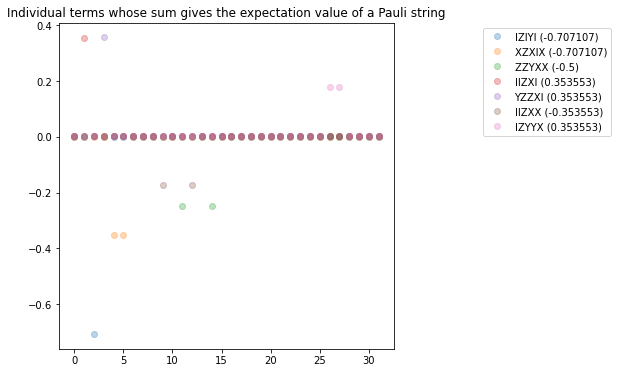

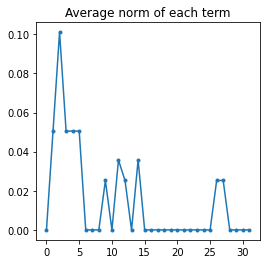

In [30]:
plot_all_heavy_terms(heavy_paulis, heis_expvals, heis_all_expvals)